<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/17_autoencoder_pro_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание light:**

Для базы Fashion-Mnist:
1. Построить CVAE c помощью глубоких полносвязных (сверточных) нейронных сетей. Добиться хорошего качества генерации изображений. Использовать различные архитектуры энкодера и декодера (количество слоев, фильтров в слоях, размеры ядер, слоев нормализации) для различных наборов гипермапараметров (оптимизатор, размер мини-выборки, количество эпох и т.д.). 
2. Ответить на вопрос: как зависит качество генерируемых изображений от размерности скрытого пространства?
 
**Задание pro:**

Для базы Cats&Dogs (или Cifar-10):
1. Выполните задание light для сверточных нейронных сетей.
2. Ответить на вопрос: как зависит качество генерируемых изображений от размерности скрытого пространства? Привести примеры.


# Подготовка окружения

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

from keras.datasets import cifar10
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Reshape, Lambda, concatenate, LeakyReLU, UpSampling2D, Conv2DTranspose, Conv2D
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard
from keras import losses

from IPython.display import clear_output

from keras.objectives import binary_crossentropy
from keras import backend as K
from keras.utils import to_categorical, plot_model

classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

Using TensorFlow backend.


# Загрузка данных

In [2]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32') / 255.
X_test  = X_test .astype('float32') / 255.

X_train = np.reshape(X_train, (len(X_train), 32, 32, 3))
X_test  = np.reshape(X_test,  (len(X_test),  32, 32, 3))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]
print("Classes: ", num_classes)

170500096/170498071 [==============================] - 2s 0us/step
Classes:  10


#Построение модели

## Гиперпараметры и константы

In [0]:
batch_size = 500
dropout_rate = 0.3
start_lr = 0.001

img_size = 32
img_channels = 3

epoch_output_interval = 5

## Утилиты

In [0]:
# Работа автокодировщика будет демонстрироваться на нескольких изображениях из начала датасета
axes_cols = 5
axes_rows = 2

def plot_images(imgs, pred, axes_rows = 2, axes_cols = 5):
    n_compare = axes_cols * axes_rows
    i = 0
    fig, axes = plt.subplots(axes_rows * 2, axes_cols, figsize=(axes_rows * 7, axes_cols / 2))
    for row in np.arange(0, axes_rows * 2, 2):
        for col in np.arange(axes_cols):
            ax = axes[row][col]
            ax.axis('off')
            ax.imshow(imgs[i])

            ax = axes[row + 1][col]
            ax.axis('off')
            ax.imshow(pred[i])
            
            i += 1
    plt.show()

## Структура сети

In [0]:
# Добавление к модели Dropout и BatchNormalization
def apply_bn_and_dropout(x):
    return Dropout(dropout_rate)(BatchNormalization()(x))


### Полносвязный автокодировщик

In [0]:
def create_dense_cvae(latent_dim):
    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        print("Sampling: [%s]" % args)
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def vae_loss(x, decoded):
        mse_loss = K.mean(losses.mse(x, decoded), axis=(1,2)) * img_size * img_size
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return mse_loss + kl_loss

    # Структура входов
    input_img = Input(shape=(img_size, img_size, img_channels), name = "Original_Image")
    input_lbl = Input(shape=(num_classes,), dtype='float32', name = "Enc_Label")
    input_lbl_d = Input(shape=(num_classes,), dtype='float32', name = "Dec_Label")
    latent = Input(shape=(latent_dim, ), name="Latent")

    # Энкодер
    flatten_img = Flatten()(input_img)

    x = concatenate([flatten_img, input_lbl])
    x = Dense(512)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    encoder  = Model(inputs = [input_img, input_lbl], outputs = l, name = 'Encoder') 
    z_meaner = Model(inputs = [input_img, input_lbl], outputs = z_mean, name = 'Enc_z_mean')
    z_lvarer = Model(inputs = [input_img, input_lbl], outputs = z_log_var, name = 'Enc_z_log_var')
    
    print("*** Encoder ***")
    encoder.summary()
    plot_model(encoder, to_file='encoder_dense.png', show_layer_names=False, show_shapes=True)

    # Декодер
    x = concatenate([latent, input_lbl_d])
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(512)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(img_size * img_size * img_channels, activation='sigmoid')(x)
    decoded = Reshape((img_size, img_size, img_channels))(x)

    decoder = Model(inputs = [latent, input_lbl_d], outputs = decoded, name='Decoder')

    print("\n\n*** Decoder ***")
    decoder.summary()
    plot_model(decoder, to_file='decoder_dense.png', show_layer_names=False, show_shapes=True)


    # Объединённая модель
    encoded = encoder([input_img, input_lbl])
    print(encoded.shape)
    cvae = Model(inputs = [input_img, input_lbl, input_lbl_d], 
                 outputs = decoder(inputs = [encoded, input_lbl_d]), 
                 name="CVAE")
    plot_model(cvae, to_file='cvae_dense.png', show_layer_names=False, show_shapes=True)

    style_transfer = Model([input_img, input_lbl, input_lbl_d], 
                           decoder([z_meaner([input_img, input_lbl]), input_lbl_d]), 
                           name="style_transfer")

    cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)
    
    return cvae, style_transfer

### Свёрточный автокодировщик

In [0]:
def create_conv_cvae(latent_dim):
    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        print("Sampling: [%s]" % args)
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def vae_loss(x, decoded):
        mse_loss = K.mean(losses.mse(x, decoded), axis=(1,2)) * img_size * img_size
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return mse_loss + kl_loss

    # Структура входов
    input_img = Input(shape=(img_size, img_size, img_channels), name = "Original_Image")
    input_lbl = Input(shape=(num_classes,), dtype='float32', name = "Enc_Label")
    input_lbl_d = Input(shape=(num_classes,), dtype='float32', name = "Dec_Label")
    latent = Input(shape=(latent_dim, ), name="Latent")

    # Encoder
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Flatten()(x)
    x = concatenate([x, input_lbl])

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    encoder  = Model(inputs = [input_img, input_lbl], outputs = l, name = 'Encoder') 
    
    # Encoder scheme
    print("\n*** Encoder ***")
    encoder.summary()
    plot_model(encoder, to_file='encoder_conv.png', show_layer_names=False, show_shapes=True)
    
    z_meaner = Model(inputs = [input_img, input_lbl], outputs = z_mean, name = 'Enc_z_mean')
    z_lvarer = Model(inputs = [input_img, input_lbl], outputs = z_log_var, name = 'Enc_z_log_var')

    # Decoder
    x = concatenate([latent, input_lbl_d])
    x = Dense(16 * 4 * 4)(x)
    x = LeakyReLU()(x)
    x = Reshape((4, 4, 16))(x)
    
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    decoder = Model(inputs = [latent, input_lbl_d], outputs = x, name='Decoder')
    
    # decoder scheme
    print("\n\n*** Decoder ***")
    decoder.summary()
    plot_model(decoder, to_file='decoder_conv.png', show_layer_names=False, show_shapes=True)

    # Объединённая модель
    encoded = encoder([input_img, input_lbl])
    print(encoded.shape)
    cvae = Model(inputs = [input_img, input_lbl, input_lbl_d], 
                 outputs = decoder(inputs = [encoded, input_lbl_d]), 
                 name="CVAE")

    style_transfer = Model([input_img, input_lbl, input_lbl_d], 
                           decoder([z_meaner([input_img, input_lbl]), input_lbl_d]), 
                           name="style_transfer")

    plot_model(cvae, to_file='cvae.png', show_layer_names=True, show_shapes=True)#, expand_nested=True)

    cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

    return cvae, style_transfer

In [0]:
create_conv_cvae(100)

### Автокодировщик без условия

In [22]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)


model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()
history = model.fit(X_train, X_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, X_test),
#                     callbacks=[es_cb, cp_cb],
                    shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 16, 32)        128       
__________

In [0]:
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
c10test = model.predict(X_train)
c10val = model.predict(X_test)

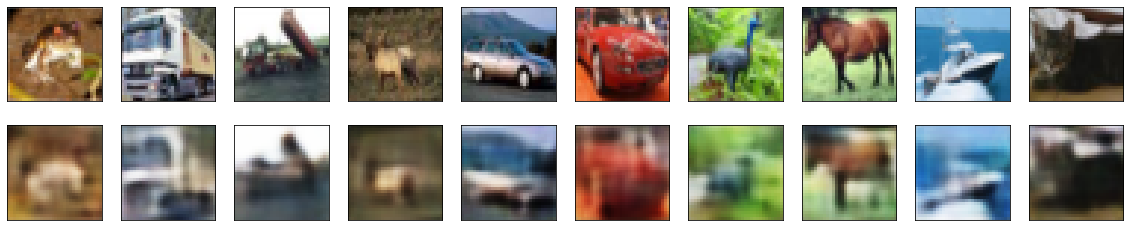

In [0]:
showOrigDec(X_train, c10test)

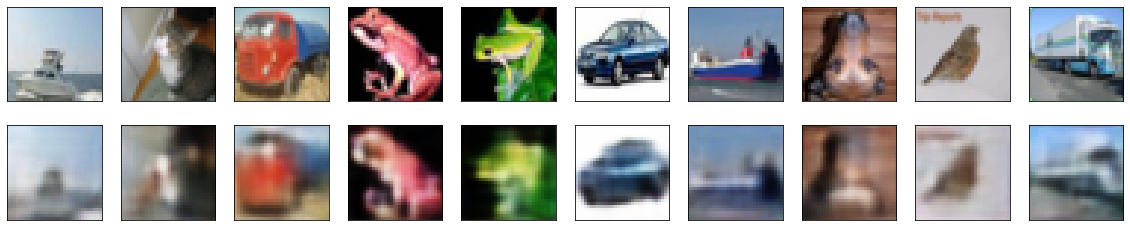

In [0]:
showOrigDec(X_train[100:], c10test[100:])

#Обучение

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


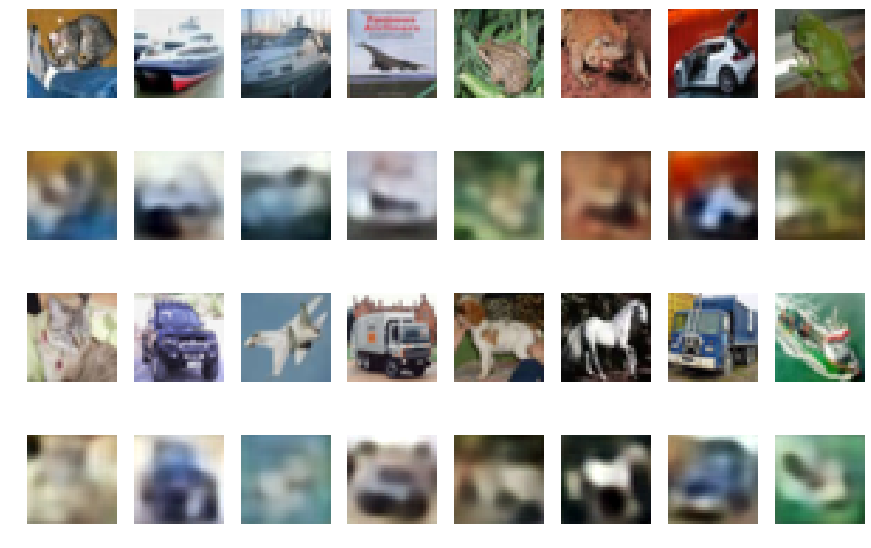

In [9]:
latent_dim = 100
imgs = X_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch > 0 and (epoch + 1) % epoch_output_interval == 0:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных изображений
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_images(imgs, decoded)

cvae, transformator = create_conv_cvae(latent_dim)

# Коллбэки
model_callbacks=[
    LambdaCallback(on_epoch_end=on_epoch_end),
    ReduceLROnPlateau(factor=0.1, patience=25)
]

# Запуск обучения

cvae.fit(x = [X_train, y_train_cat, y_train_cat], 
         y = X_train, 
         shuffle = True, 
         epochs = 50,
         batch_size = batch_size,
         validation_data = ([X_test, y_test_cat, y_test_cat], X_test),
         callbacks = model_callbacks,
         verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


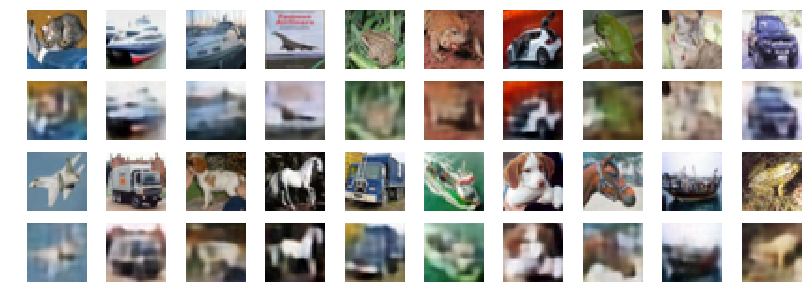

In [82]:
pred = cvaes[-1].predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
plot_images(imgs, pred, 2, 10)

## Копирование стиля

In [0]:
def transfer_style(model, X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        lbl = lbl_in
        lbl_in = np.zeros((rows, 10))
        lbl_in[:, lbl] = 1
    if isinstance(lbl_out, int):
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10))
        lbl_out[:, lbl] = 1
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out])

n = 10
lbl = 5
generated = []
prot = X_train[(y_train == lbl).flatten()][:n]

for i in range(num_classes):
    generated.append(transfer_style(transformator, prot, lbl, i))

# generated[lbl] = prot


In [0]:
axes_cols = 10
axes_rows = 10
n_compare = axes_cols * axes_rows

i = 0
fig, axes = plt.subplots(axes_rows, axes_cols, figsize=(15, 15))
for row in np.arange(axes_rows):
    for col in np.arange(axes_cols):
        ax = axes[row][col]
        ax.axis('off')
        ax.imshow((generated[row][col] * 255).astype(np.uint8))
#         ax.imshow(generated[row][col])

        i += 1
plt.show()

# Сравнение работы автокодировщиков с разным размером скрытого пространства

## Обучение нейросетей

In [0]:
latent_dims = [8, 10, 20, 50, 75, 100, 200, 300]
cvaes = []
for dim in latent_dims:
    print("**** Latent %s ****" % dim)
    v, t = create_conv_cvae(dim)
    
    v.fit(x = [X_train, y_train_cat, y_train_cat], 
             y = X_train, 
             shuffle = True, 
             epochs = 100,
             batch_size = batch_size,
             validation_data = ([X_test, y_test_cat, y_test_cat], X_test),
#              callbacks = model_callbacks,
             verbose=1)
    cvaes.append(v)
    


Дообучение

In [57]:
for cvae in cvaes[-3:]:
    v.fit(x = [X_train, y_train_cat, y_train_cat], 
             y = X_train, 
             shuffle = True, 
             epochs = 200,
             batch_size = batch_size,
             validation_data = ([X_test, y_test_cat, y_test_cat], X_test),
             verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 11s 230us/step - loss: 6.7269 - val_loss: 6.6805
Epoch 2/200
50000/50000 [==============================] - 11s 228us/step - loss: 6.6946 - val_loss: 6.7975
Epoch 3/200
50000/50000 [==============================] - 11s 229us/step - loss: 6.6842 - val_loss: 6.6932
Epoch 4/200
50000/50000 [==============================] - 12s 231us/step - loss: 6.6997 - val_loss: 6.7343
Epoch 5/200
50000/50000 [==============================] - 11s 229us/step - loss: 6.7178 - val_loss: 6.7854
Epoch 6/200
50000/50000 [==============================] - 12s 232us/step - loss: 6.7076 - val_loss: 6.7291
Epoch 7/200
50000/50000 [==============================] - 12s 232us/step - loss: 6.7127 - val_loss: 6.6974
Epoch 8/200
50000/50000 [==============================] - 12s 231us/step - loss: 6.7169 - val_loss: 6.7818
Epoch 9/200
50000/50000 [==============================] - 12s 232us/step - loss: 6.70

## Демонстрация работы

In [32]:
len(cvaes)

8

### 200 эпох обучения

Latent 8


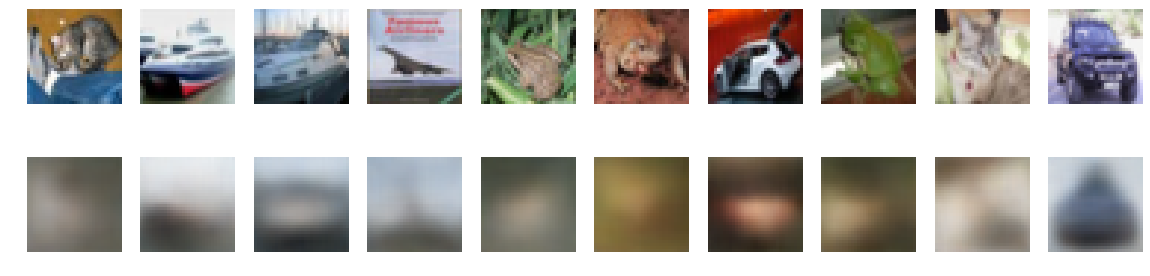

Latent 10


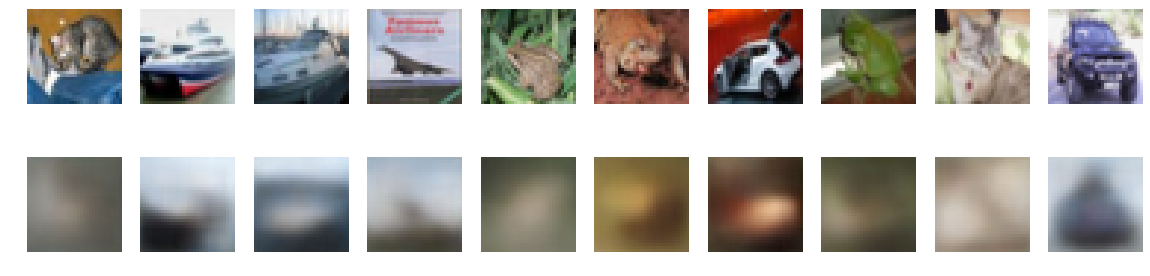

Latent 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


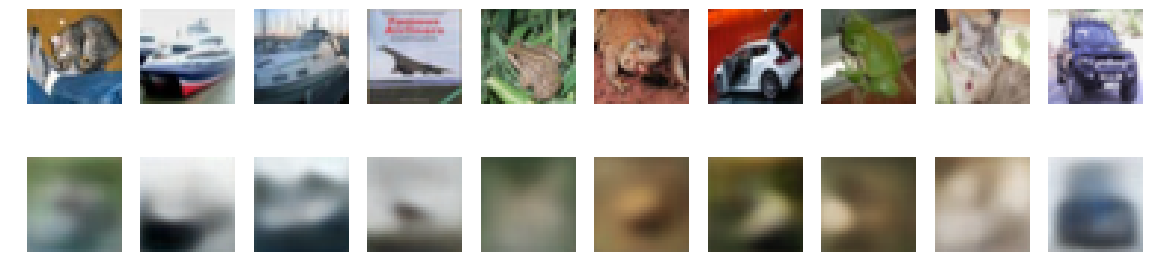

Latent 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


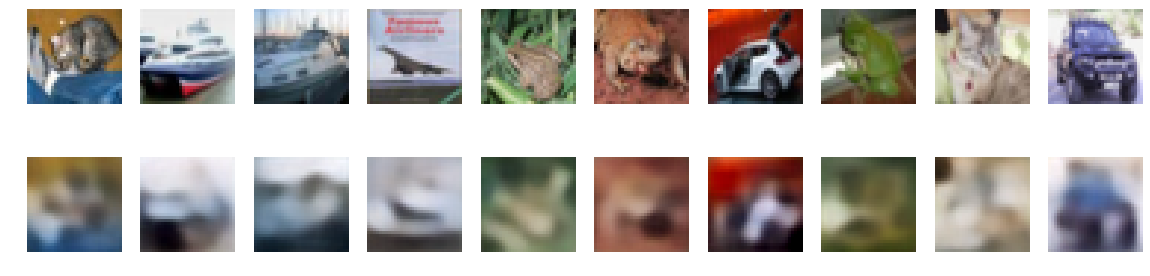

Latent 75


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


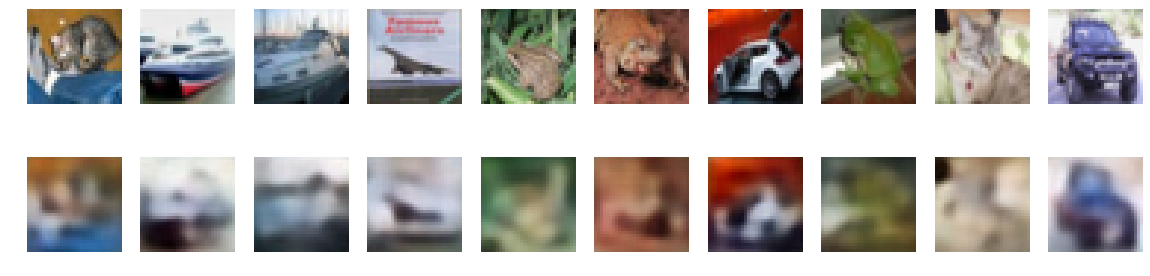

Latent 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


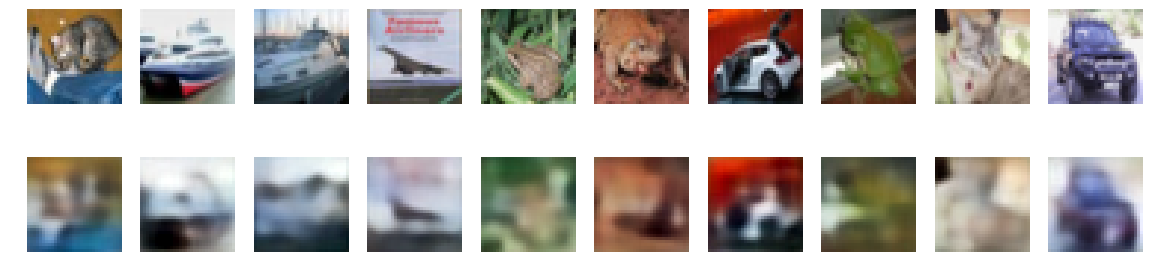

Latent 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


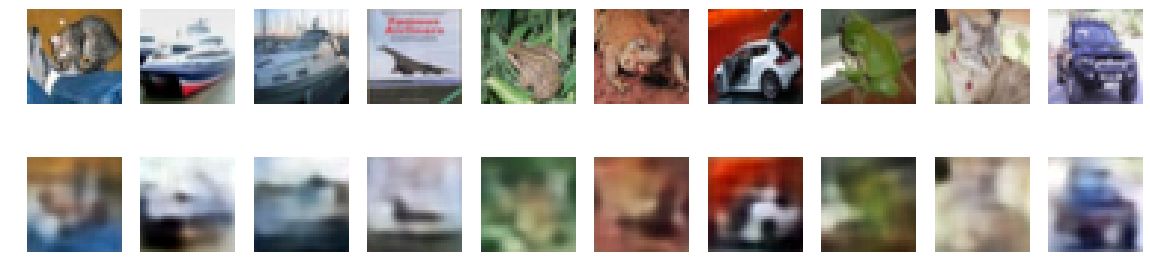

Latent 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


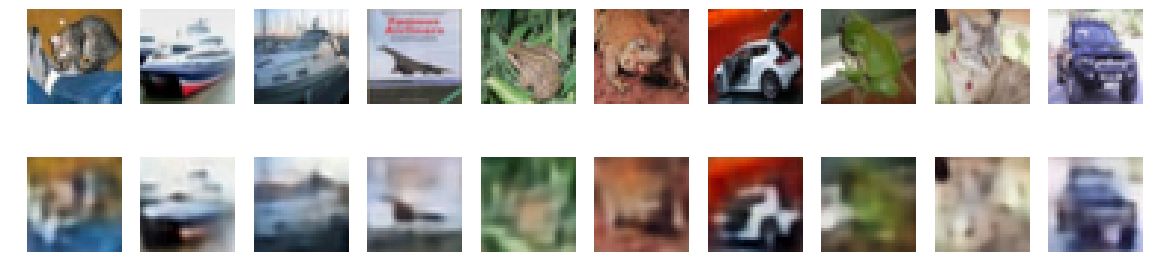

In [56]:
imgs = X_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]

i = 0
for i in range(len(latent_dims)):
    print("Latent %s" % latent_dims[i])
    ae = cvaes[i]
    pred = ae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
    plot_images(imgs, pred, 1, 10)


### 400 эпох обучения

Следующие сети (только latent == 100, 200, 300) были обучены на 400 эпохах

Latent 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


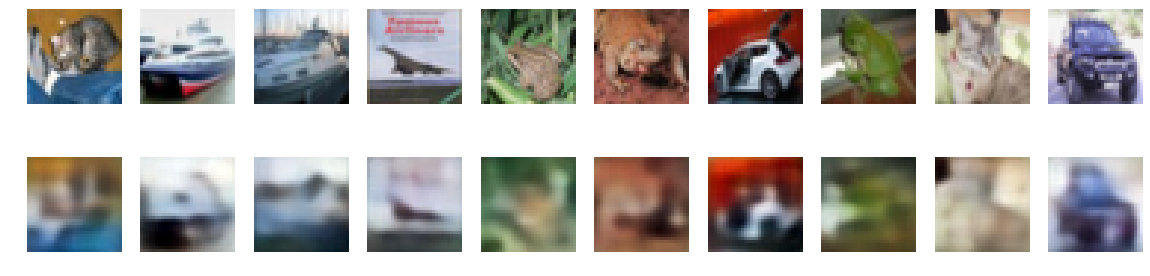

Latent 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


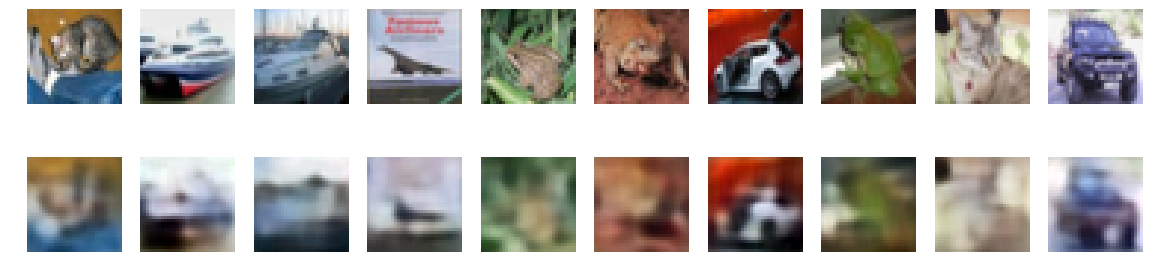

Latent 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


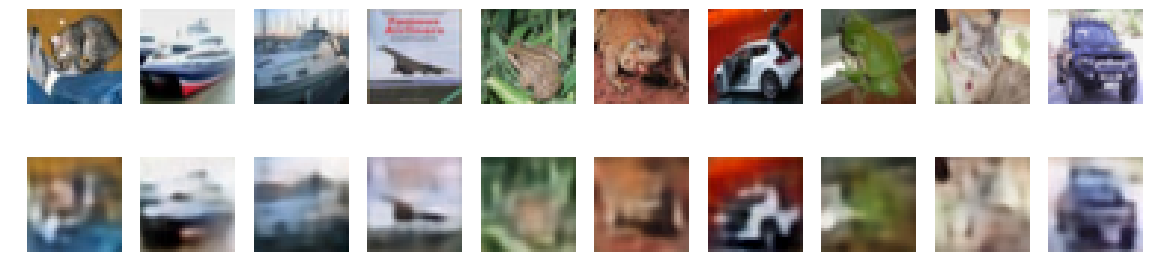

In [58]:
imgs = X_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]

i = 0
for i in range(len(latent_dims))[-3:]:
    print("Latent %s" % latent_dims[i])
    ae = cvaes[i]
    pred = ae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
    plot_images(imgs, pred, 1, 10)
